In [346]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

import pymc3 as pm

from patsy import dmatrix

In [2]:
pos = [np.random.uniform(-1, 1, 16).sum() for i in range(1000)]

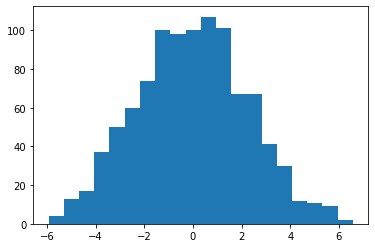

In [7]:
plt.hist(pos,
         bins=20
        );

In [87]:
steps = np.arange(0, 17, 1)
pos = np.zeros((len(steps), num_people))

In [89]:
for i in range(num_people):
    pos[1:, i] = np.random.uniform(-1, 1, len(steps)-1).cumsum() 

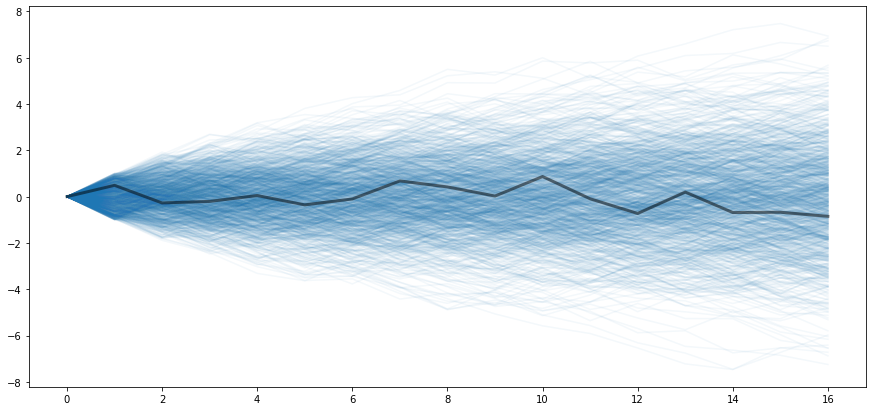

In [91]:
_, ax = plt.subplots(figsize=(15, 7))
ax.plot(steps, pos, "C0-", alpha=0.05)
ax.plot(steps, pos[:, 0], "k-", alpha=0.5, linewidth=3)

### Gaussian model of height

In [7]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")

In [8]:
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


array([[<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'male'}>]], dtype=object)

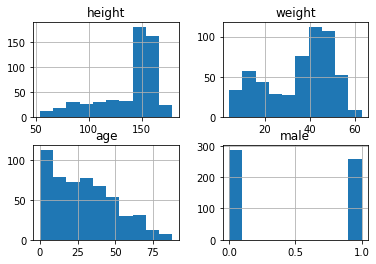

In [9]:
df.hist()

In [12]:
height = (df
          .query("age > 18")
          .loc[:, "height"]).values

<AxesSubplot:>

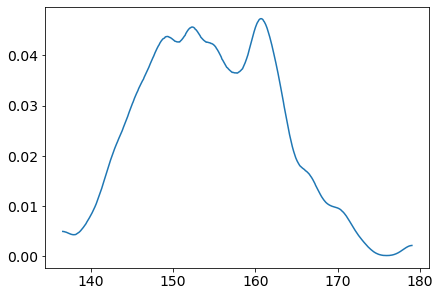

In [13]:
az.plot_kde(height)

In [16]:
mu_prior = stats.norm(loc=178, scale=20)
sd_prior = stats.uniform(loc=0, scale=50)

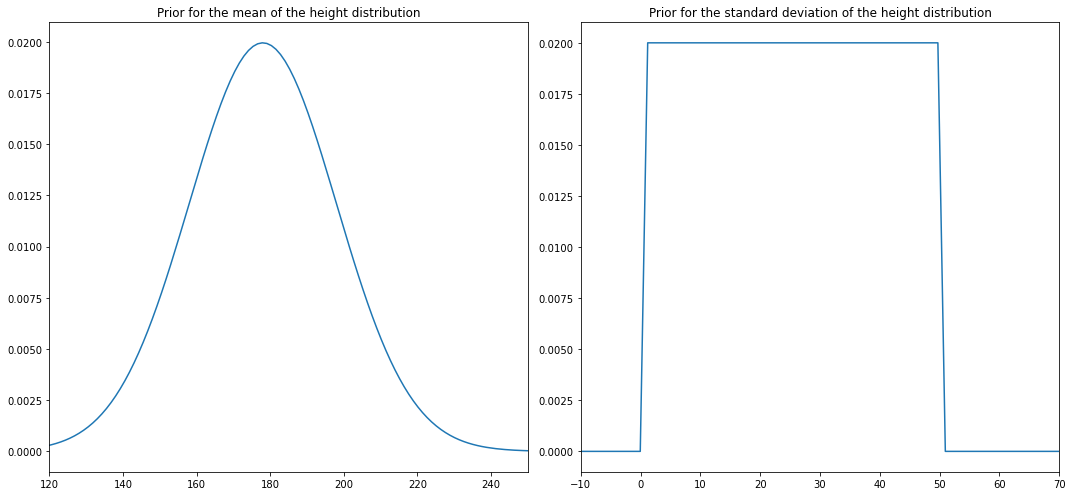

In [18]:
h_grid = np.linspace(-10, 250, 210)

_, axes = plt.subplots(1, 2, figsize=(15,7))
axes[0].plot(h_grid, mu_prior.pdf(h_grid), "C0-")
axes[0].set_title("Prior for the mean of the height distribution")
axes[0].set_xlim(120, 250)
axes[1].plot(h_grid, sd_prior.pdf(h_grid), "C0-")
axes[1].set_title("Prior for the standard deviation of the height distribution")
axes[1].set_xlim(-10, 70)
plt.tight_layout()

#### Prior predictive simulation

In [65]:
n_samples = 10_000
prior_sample_mu = mu_prior.rvs(n_samples)
prior_sample_sd = sd_prior.rvs(n_samples)
h_prior = stats.norm.rvs(loc=prior_sample_mu, scale=prior_sample_sd)

<AxesSubplot:>

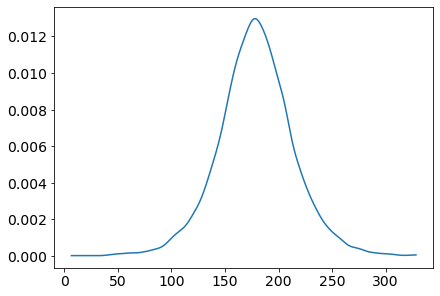

In [20]:
az.plot_kde(h_prior)

#### Grid approximation of posterior distribution

In [61]:
# Define sets of priors
mu_grid = np.linspace(150, 160, 100)
sd_grid = np.linspace(7, 9, 100)
Mu, Sd = np.meshgrid(mu_grid, sd_grid)

# Define likelihood
like = [sum(stats.norm.logpdf(height, loc=Mu.ravel()[i], scale=Sd.ravel()[i])) for i in range(len(Mu.ravel()))]

# Define log posterior
log_posterior = like + mu_prior.logpdf(Mu.ravel()) + sd_prior.logpdf(Sd.ravel())

# Untandardized posterior
unst_post = np.exp(log_posterior - log_posterior.max())

#Standardized posterior 
posterior = (unst_post/(unst_post).sum()).reshape(100, -1)

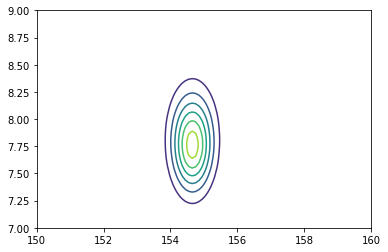

In [62]:
plt.contour(Mu, Sd, posterior)

#### Sampling the posterior distribution

In [69]:
sample_param_tuple = np.random.choice(np.arange(len(posterior.ravel())),
                                      size=10_000,
                                      replace=True,
                                      p=posterior.ravel())

In [71]:
post_sample_mu = Mu.ravel()[sample_param_tuple]
post_sample_sd = Sd.ravel()[sample_param_tuple]

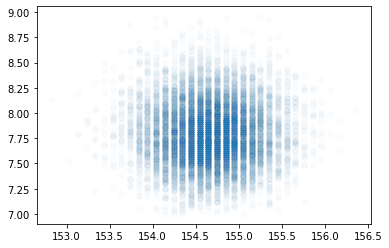

In [77]:
plt.scatter(post_sample_mu, post_sample_sd, color="C0", alpha=0.02, s=30)

<AxesSubplot:>

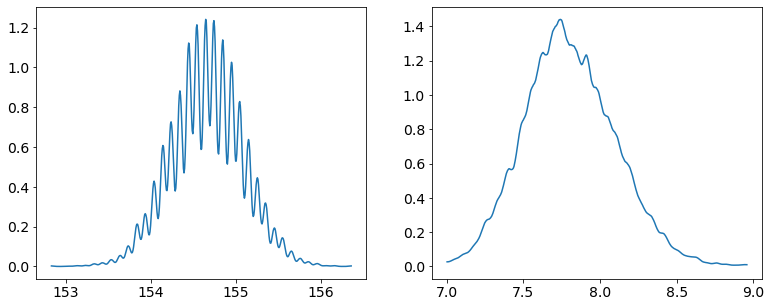

In [79]:
_, axes = plt.subplots(1, 2, figsize=(13, 5))

az.plot_kde(post_sample_mu, ax=axes[0])
az.plot_kde(post_sample_sd, ax=axes[1])

#### Reduced data set

In [80]:
np.size(height)

346

In [85]:
height_red = height[::12]

As an exercise we repeat the previous calculation

In [91]:
mu_grid = np.linspace(150, 170, 200)
sd_grid = np.linspace(4, 20, 200)
Mu, Sd = np.meshgrid(mu_grid, sd_grid)
mus, sds = Mu.ravel(), Sd.ravel()

# Define priors
prior_mu = stats.norm(loc=178, scale=20)
prior_sd = stats.uniform(loc=0, scale=50)

# Define log likelihood
log_like = [sum(stats.norm.logpdf(height_red, loc=mus[i], scale=sds[i])) for i in range(len(mus))]

# Define log posterior
log_post = log_like + prior_mu.logpdf(mus) + prior_sd.logpdf(sds)

# Define unstandardized posterior
unst_post = np.exp(log_post - max(log_post))

# Define standardized posterior
posterior = unst_post/unst_post.sum()

# Sample rows from posterior distribution
post_sample_tuple = np.random.choice(np.arange(len(posterior)),
                                     size=10_000,
                                     replace=True, 
                                     p=posterior)
post_sample_mu = mus[post_sample_tuple]
post_sample_sd = sds[post_sample_tuple]

<AxesSubplot:>

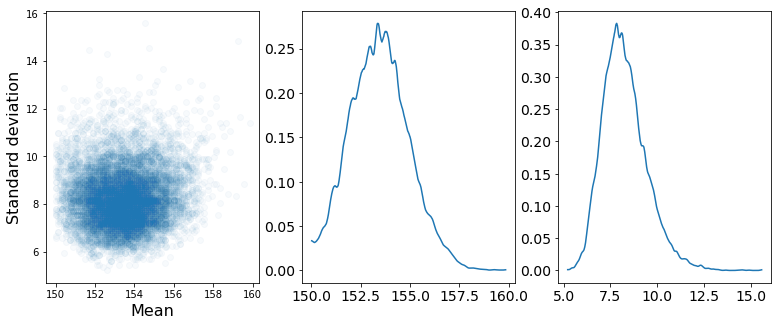

In [92]:
_, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].plot(post_sample_mu, post_sample_sd, "C0o", alpha=0.03)
axes[0].set_xlabel("Mean", fontsize=16)
axes[0].set_ylabel("Standard deviation", fontsize=16)

az.plot_kde(post_sample_mu, ax=axes[1])
axes[1].

az.plot_kde(post_sample_sd, ax=axes[2])

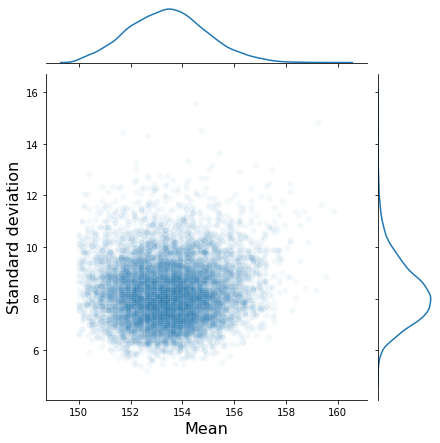

In [100]:
g = sns.JointGrid(x=post_sample_mu, y=post_sample_sd)
g.plot(sns.scatterplot, sns.kdeplot, alpha=0.05)
g.set_axis_labels('Mean', 'Standard deviation', fontsize=16)



### Quadratic approximation

In [103]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")
height_obs = (df
              .query("age > 18")
              .loc[:, "height"])

In [104]:
# Model definition

with pm.Model() as quad_approx_test:
    # Define priors
    prior_mu = pm.Normal("prior_mu",
                         mu=178,
                         sd=20)
    prior_sd = pm.Uniform("prior_sd",
                          lower=0,
                          upper=50)
    
    # Define likelihood
    height = pm.Normal("height",
                       mu=prior_mu,
                       sd=prior_sd,
                       observed=height_obs
                      )

In [116]:
with quad_approx_test:
    # find posterior mode 
    mean_q = pm.find_MAP(maxeval=10000)
    # find curvature at the mode of the posterior
    std_q = ((1 / pm.find_hessian(mean_q, 
                                  vars=[prior_mu, prior_sd],
                                 )) ** 0.5)

In [117]:
mean_q

{'prior_mu': array(154.65453238),
 'prior_sd_interval__': array(-1.69403006),
 'prior_sd': array(7.76232913)}

In [118]:
std_q

array([[0.41721459, 8.15476211],
       [8.15476211, 0.29507948]])

In [119]:
cov = [[0.17, 0.00022], [0.00022, 0.085]]

In [120]:
# Generate two dimensional gaussian representing the combined posterior for mu and standard deviation

posterior = stats.multivariate_normal(mean=[mean_q["prior_mu"], mean_q["prior_sd"]], 
                                      cov=cov)

In [121]:
samples = posterior.rvs(10_000)

Text(0.5, 1.0, 'Distribution of standard deviation')

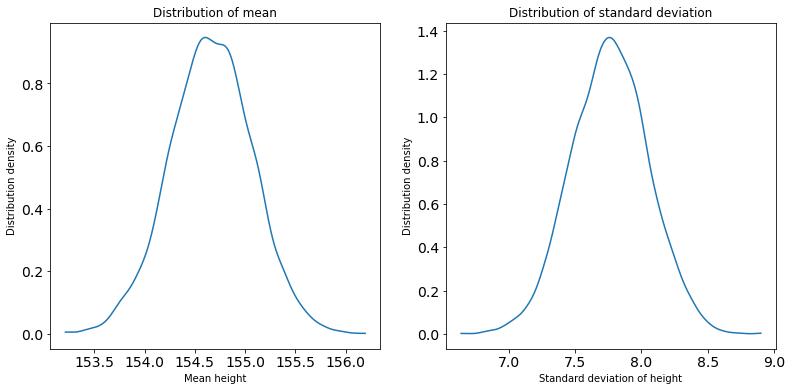

In [128]:
_, axes = plt.subplots(1, 2, figsize=(13, 6))

az.plot_kde(samples[:, 0], ax=axes[0])
axes[0].set_xlabel("Mean height")
axes[0].set_ylabel("Distribution density")
axes[0].set_title("Distribution of mean")
az.plot_kde(samples[:, 1], ax=axes[1])
axes[1].set_xlabel("Standard deviation of height")
axes[1].set_ylabel("Distribution density")
axes[1].set_title("Distribution of standard deviation")

In [134]:
az.summary(samples[:, 0], kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,154.658,0.411,153.865,155.421


In [133]:
az.summary(samples[:, 1], kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,7.759,0.291,7.238,8.328


### Linear predictions

In [176]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")
adults = df.query("age >= 18")
height_obs = adults["height"].values
weight = adults["weight"].values

Text(0, 0.5, 'Height')

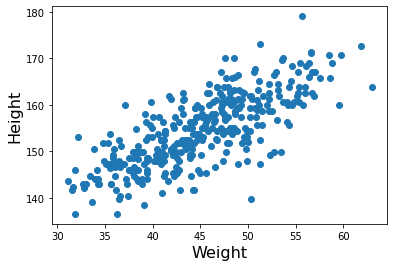

In [138]:
plt.scatter(weight, height, c="C0")
plt.xlabel("Weight", fontsize=16)
plt.ylabel("Height", fontsize=16)

In [155]:
# Parameters

np.random.seed(101)
num_samples = 100
std_weight = (weight - weight.mean())

In [156]:
# Naive model

# Define priors
alpha = stats.norm(loc=178, scale=20)
beta = stats.norm(loc=0, scale=10)

# Simulation of prior predictive distribution 
prior_alpha_samples = alpha.rvs(num_samples)
prior_beta_samples = beta.rvs(num_samples)
prior_height_samples = [prior_alpha_samples[i] 
                        + prior_beta_samples[i] * std_weight
                        for i in range(num_samples)]

In [161]:
# Log-normal model

# Define priors
alpha_log = stats.norm(loc=178, scale=20)
beta_log = stats.lognorm(scale=1, s=1)

# Simulation of prior predictive distribution for log-normal model 

prior_alpha_log_samples = alpha_log.rvs(num_samples)
prior_beta_log_samples = beta_log.rvs(num_samples)
prior_height_log_samples = [prior_alpha_log_samples[i] 
                        + prior_beta_log_samples[i] * std_weight
                        for i in range(num_samples)]

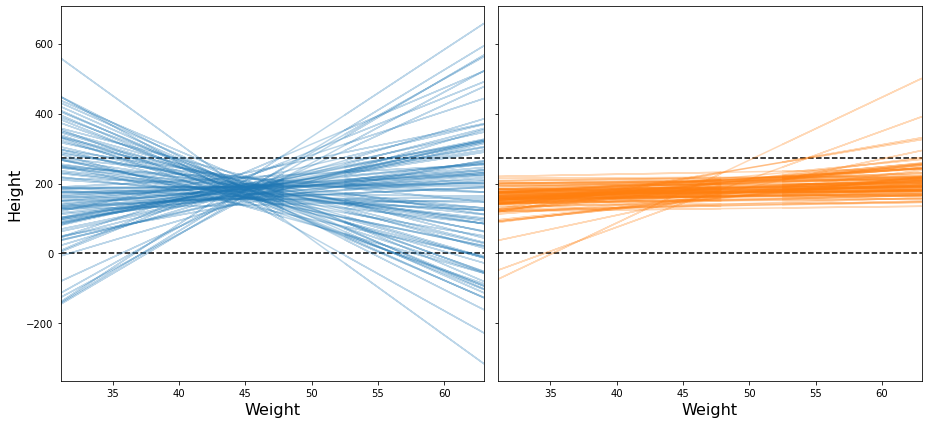

In [175]:
_, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)

for test_i in range(num_samples):
    axes[0].plot(weight, prior_height_samples[test_i], "C0-", alpha=0.3)
    axes[1].plot(weight, prior_height_log_samples[test_i], "C1-", alpha=0.3)
axes[0].hlines(y=[0, 272], 
                xmin=weight.min(), 
                xmax=weight.max(), 
                color="k", 
                linestyle="--"
               )
axes[0].set_xlim(weight.min(), weight.max())
axes[0].set_xlabel("Weight", fontsize=16)
axes[0].set_ylabel("Height", fontsize=16)
axes[1].hlines(y=[0, 272], 
                xmin=weight.min(), 
                xmax=weight.max(), 
                color="k", 
                linestyle="--"
               )
axes[1].set_xlim(weight.min(), weight.max())
axes[1].set_xlabel("Weight", fontsize=16)
plt.tight_layout()

#### Build model with pymc3

In [177]:
with pm.Model() as lin_model:
    # Priors
    alpha = pm.Normal("alpha",
                      mu=178,
                      sd=20)
    beta = pm.Lognormal("beta",
                        mu=0,
                        sd=1)
    height_sd = pm.Uniform("height_sd",
                           0,
                           50)
    
    height_mu = pm.Deterministic("height_mu",
                                 alpha + beta*std_weight)
    
    # Likelihood
    height = pm.Normal("height",
                       mu=height_mu,
                       sd=height_sd,
                       observed=height_obs)
    
    # Sample posterior
    lin_trace = pm.sample(10_000,
                          return_inferencedata=True,
                          tune=2000)

<ipython-input-177-0cd7b39469d2>:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  lin_trace = pm.sample(10_000,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [height_sd, beta, alpha]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 43 seconds.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'height_mu'}>,
        <AxesSubplot:title={'center':'height_mu'}>]], dtype=object)

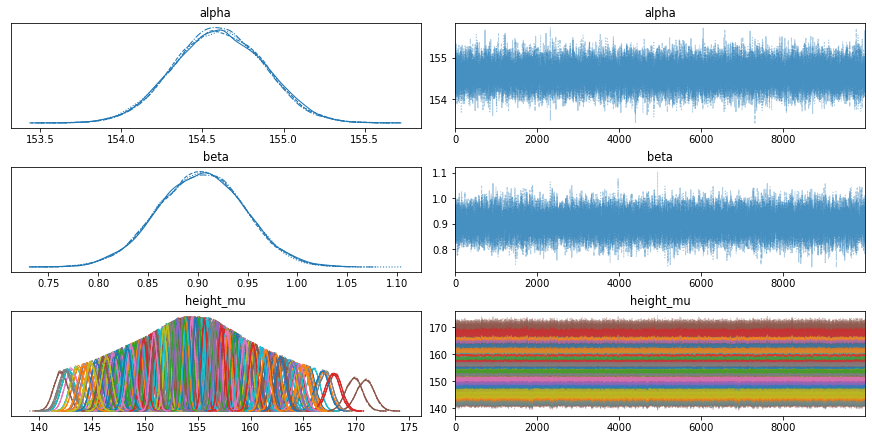

In [179]:
az.plot_trace(lin_trace, var_names=["alpha", "beta", "height_mu"])

In [183]:
az.summary(lin_trace, var_names=["alpha", "beta", "height_sd"], kind="stats")

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,154.602,0.277,154.088,155.119
beta,0.903,0.043,0.821,0.983
height_sd,5.103,0.195,4.740,5.463


In [185]:
lin_trace_df = pm.trace_to_dataframe(lin_trace,
                                     varnames=["alpha", "beta", "height_sd"])

In [186]:
lin_trace_df.head()

,alpha,beta,height_sd
0,154.645159,0.903443,5.125594
1,154.645159,0.903443,5.125594
2,154.285257,0.895741,5.146660
3,154.827549,0.950148,5.068496
4,154.362906,0.906868,5.110590


In [188]:
lin_trace_df.cov().round(3)

,alpha,beta,height_sd
alpha,0.076,-0.000,0.000
beta,-0.000,0.002,-0.000
height_sd,0.000,-0.000,0.038


#### Plotting posterior inference data

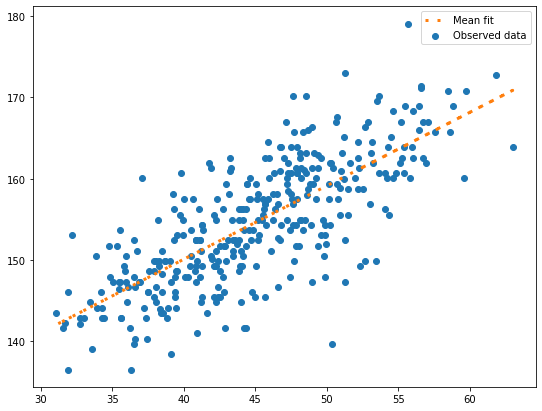

In [198]:
_, ax = plt.subplots(figsize=(9,7))
ax.scatter(weight,
           height_obs,
           label="Observed data"
          )
ax.plot(weight,
        lin_trace_df["alpha"].mean() + lin_trace_df["beta"].mean()*(std_weight),
        color="C1",
        linewidth=3,
        linestyle="--",
        dashes=[1,3],
        label="Mean fit")
ax.legend()

#### Remodeling with a smaller dataset

In [222]:
height_obs = adults["height"][:10].values
weight = adults["weight"][:10].values
std_weight = weight - weight.mean()

In [226]:
height_obs

array([151.765, 139.7  , 136.525, 156.845, 145.415, 163.83 , 149.225,
       168.91 , 147.955, 165.1  ])

In [227]:
weight

array([47.8256065, 36.4858065, 31.864838 , 53.0419145, 41.276872 ,
       62.992589 , 38.2434755, 55.4799715, 34.869885 , 54.487739 ])

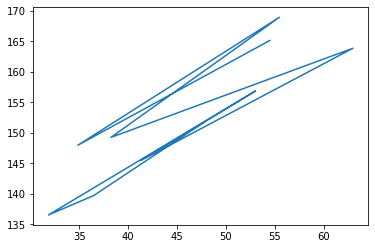

In [223]:
plt.plot(weight, height_obs)

In [230]:
with pm.Model() as lin_red_model:
    # Priors
    alpha = pm.Normal("alpha",
                      mu=178,
                      sd=100)
    beta = pm.Lognormal("beta",
                        mu=0,
                        sd=1)
    h_mu = pm.Deterministic("h_mu",
                            alpha + beta*std_weight)
    eps = pm.Uniform("eps",
                     0,
                     50)
    
    # Likelihood
    h = pm.Normal("h",
                  mu=h_mu,
                  sd=eps,
                  observed=height_obs)

    # Sampler step
#     step = pm.Metropolis()    

In [231]:
# Sample posterior
with lin_red_model:
    lin_red_trace = pm.sample(1_000, 
                              tune=1000,
#                               step=step,
                              return_inferencedata=False)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [234]:
lin_red_trace_df = pm.trace_to_dataframe(lin_red_trace)

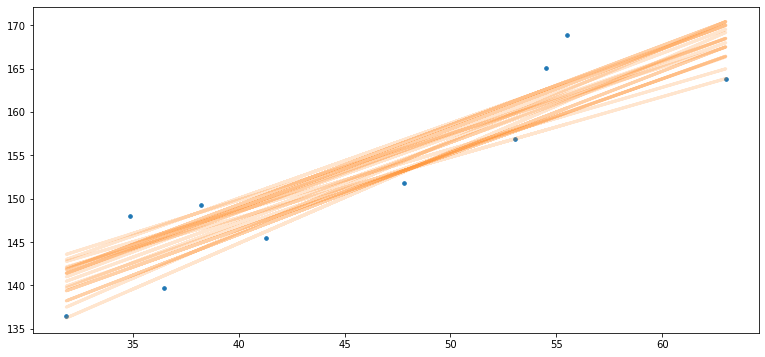

In [238]:
_, ax = plt.subplots(figsize=(13, 6))

ax.scatter(weight, 
           height_obs,
           label="Observed data",
           color="C0",
           s=13)

for i in range(20):
    ax.plot(weight,
            lin_red_trace_df["alpha"][i] + lin_red_trace_df["beta"][i]*std_weight,
            color="C1",
            linewidth=3,
            alpha=0.2)


#### Plotting regression intervals

In [243]:
mu_at_50 = lin_red_trace["alpha"] + lin_red_trace["beta"]*(50 - weight.mean()) 

<AxesSubplot:>

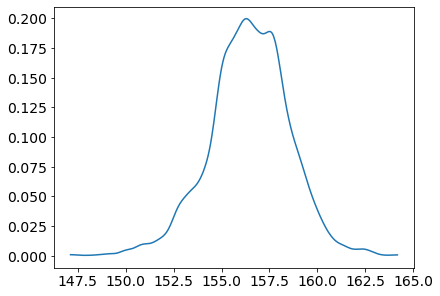

In [244]:
az.plot_kde(mu_at_50)

In [245]:
az.hdi(mu_at_50)

array([152.46655916, 160.20272729])

In [246]:
mu = lin_red_trace["h_mu"]

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


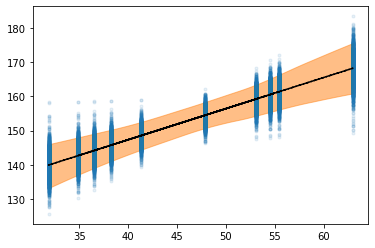

In [265]:
plt.plot(weight,
         np.transpose(mu),
         "C0.",
         alpha=0.1);
az.plot_hdi(weight,
            mu)
plt.plot(weight,
         lin_red_trace["h_mu"].mean(0),
         "k--"
        )

#### Prediction intervals

In pymc3 we use ```sample_posterior_predictive()``` to find the distribution of the posterior distribution (different from above where we were looking at only the distribution of the mean). This function gives us posterior predictive samples, that is for each value of the input variable (weight in this case) we get a sample (from the posterior) of the output variable. Thus in the following example the shape of `height_pred['height']` will be (200, 10) since we only considered 10 data points in the model (and hence 10 values of weights). I think that here is where if you have a shared variable in the model you can obtain samples also for values of the indipendent variables that are different from those connected to the data.

Notice that, while the `trace` is a series of possible values for the parameters, when we use sample_posterior_predictive we actually obtain the value for the outcome of interest (in this case the height). As in previous chapters, the predictive samples are a sort of distribution of the outcomes obtained from a weighed average of distributions associated to the various possible values of the parameters.

In [266]:
height_samples = pm.sample_posterior_predictive(lin_red_trace,
                                                samples=200,
                                                model=lin_red_model)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Compared to `mu` above, height_samples contains full simulated values of the height and not only of the average

In [271]:
height_samples["h"].shape

(200, 10)

In [275]:
h_hdi = az.hdi(height_samples["h"], hdi_prob=0.89)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


In [279]:
h_hdi[:, 0]

array([142.34266219, 134.56220509, 129.81697768, 147.71853211,
       139.1091701 , 155.90902731, 136.62602148, 150.97962044,
       134.26336568, 149.53368299])

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

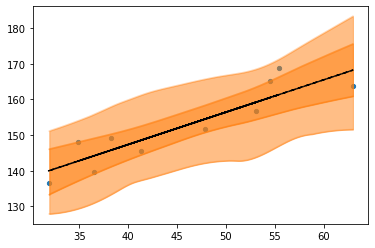

In [282]:
plt.scatter(weight,
            height_obs,
            color="C0",
            s=18)
plt.plot(weight,
         lin_red_trace["h_mu"].mean(0),
         "k--")
az.plot_hdi(weight,
            lin_red_trace["h_mu"],
            color="C1",
            plot_kwargs={"alpha": 0.6}
           )
az.plot_hdi(weight,
            height_samples["h"],
            color="C1",
            plot_kwargs={"alpha":0.3}
           )

### Polynomial regression

In [283]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")

In [285]:
df.columns

Index(['height', 'weight', 'age', 'male'], dtype='object')

<AxesSubplot:xlabel='weight', ylabel='height'>

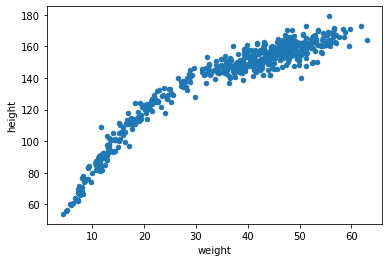

In [287]:
df.plot(
    x="weight",
    y="height",
    kind="scatter"
)

In [289]:
height_obs = df["height"]
weight_obs = df["weight"]
weight_std = (weight_obs - weight_obs.mean())/weight_obs.std()

In [296]:
# Define model

with pm.Model() as poly_model:
    #Shared variables
    W = pm.Data("W",
                weight_std)
    # Priors
    alpha = pm.Normal("alpha",
                      mu=178,
                      sd=20)
    beta1 = pm.Lognormal("beta1",
                         mu=0,
                         sd=1)
    beta2 = pm.Normal("beta2",
                      mu=0,
                      sd=1)
    h_sd = pm.Uniform("h_sd",
                      0,
                      50)
    h_mu = pm.Deterministic("h_mu",
                            alpha + beta1*W + beta2*W**2)
    
    # Likelihood
    h = pm.Normal("h",
                  mu=h_mu,
                  sd=h_sd,
                  observed=height_obs)

In [297]:
with poly_model:
    poly_trace = pm.sample(1000,
                           tune=1000,
                           return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h_sd, beta2, beta1, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [298]:
az.summary(poly_trace, var_names=["~h_mu"], kind="stats", round_to=2)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,146.05,0.37,145.32,146.73
beta2,-7.80,0.27,-8.28,-7.26
beta1,21.73,0.29,21.16,22.27
h_sd,5.80,0.18,5.46,6.12


C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'h_sd'}>,
        <AxesSubplot:title={'center':'h_sd'}>]], dtype=object)

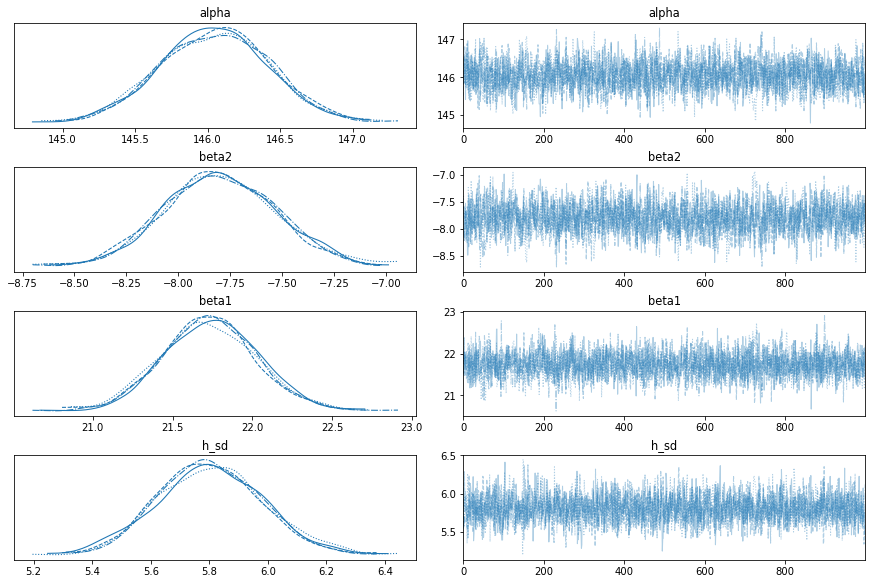

In [299]:
az.plot_trace(poly_trace, var_names=["~h_mu"])

We can sample from the posterior at values of the weights that were not observed thanks to the definition of W as a shared variable

In [301]:
weight_seq = np.linspace(-2.2, 2, 30)

In [306]:
with poly_model:
    pm.set_data({"W":weight_seq})
    h_samples = pm.sample_posterior_predictive(poly_trace,
                                               samples=200)

In [304]:
h_samples

{'h': array([[ 46.80170128,  65.87060536,  74.0519679 , ..., 171.35815248,
         167.8810623 , 154.27008885],
        [ 55.34513316,  66.84146874,  68.96276731, ..., 156.48213568,
         148.71009978, 156.35485253],
        [ 60.07262132,  71.72570172,  75.45102532, ..., 157.97267951,
         168.86428867, 172.39063828],
        ...,
        [ 59.70078431,  62.91950042,  69.73632122, ..., 167.80087916,
         157.01914173, 159.8180464 ],
        [ 58.51492203,  72.57543567,  81.30742951, ..., 152.78927308,
         167.83044455, 156.70736237],
        [ 62.9135641 ,  76.04404515,  86.64724185, ..., 157.76277134,
         157.3176029 , 161.46313968]])}

In [317]:
np.shape(weight_std)

(544,)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

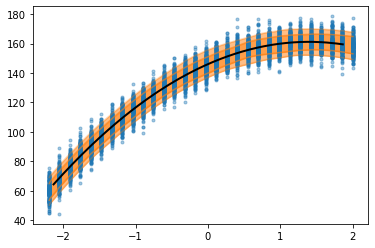

In [322]:
plt.plot(weight_seq, 
         np.transpose(h_samples["h"]),
         "C0.",
         alpha=0.4
        );
idxs = np.argsort(weight_std)
plt.plot(weight_std[idxs],
         poly_trace["h_mu"].mean(0)[idxs],
         "k",
         linewidth=2
        )
az.plot_hdi(weight_seq,
            h_samples["h"], 
            hdi_prob=0.67,
            plot_kwargs={"alpha": 0.6})
az.plot_hdi(weight_seq,
            h_samples["h"],
            hdi_prob=0.89,
            plot_kwargs={"alpha": 0.3})

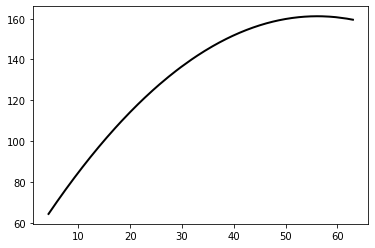

In [325]:
idxs = np.argsort(weight_std)
plt.plot(weight_obs[idxs],
         poly_trace["h_mu"].mean(0)[idxs],
         "k",
         linewidth=2
        )

### Spline regression

In [330]:
df = pd.read_csv("../Data/cherry_blossoms.csv")

In [333]:
df.describe()

,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
25%,1104.500000,100.000000,5.700000,6.480000,4.610000
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
75%,1711.500000,109.000000,6.530000,7.720000,5.542500
max,2015.000000,124.000000,8.300000,12.100000,7.740000


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'doy'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'temp_upper'}>],
       [<AxesSubplot:title={'center':'temp_lower'}>, <AxesSubplot:>]],
      dtype=object)

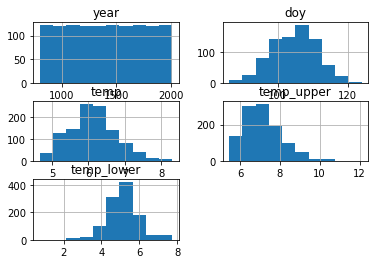

In [334]:
df.hist()

<AxesSubplot:xlabel='year'>

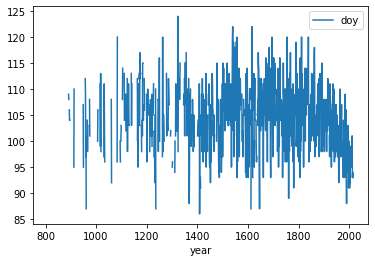

In [336]:
df.plot(x="year",
        y="doy")

In [372]:
# Variables
year_obs = df.dropna(subset=["doy"])["year"]
doy_obs = df.dropna(subset=["doy"])["doy"]

In [373]:
# Generate knots positions
num_knots = 15
knot_list = np.quantile(year_obs, q=np.linspace(0, 1, num_knots))

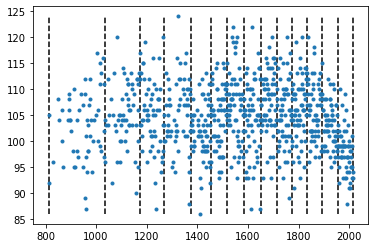

In [374]:
plt.plot(year_obs, 
         doy_obs,
         "C0.")
plt.vlines(knot_list, 
           ymin=doy_obs.min(),
           ymax=doy_obs.max(),
           colors="k",
           linestyle="--")

In [375]:
fml = "bs(year, knots=knots, degree=3) - 1"
B = dmatrix(fml,
            data={"year": year_obs,
                  "knots": knot_list[1:-1]}
           )

In [376]:
B.shape

(827, 16)

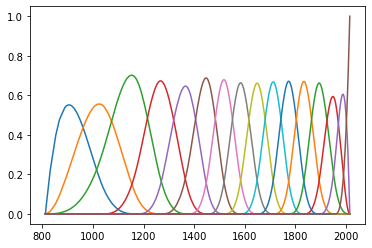

In [377]:
plt.plot(year_obs,
         B);

In [392]:
# Define the model
with pm.Model() as spline_model:
    # Priors
    alpha = pm.Normal("alpha",
                      mu=100,
                      sd=10)
    weights = pm.Normal("weights",
                        mu=0,
                        sd=10,
                        shape=B.shape[1])
    doy_mu = pm.Deterministic("doy_mu",
                              alpha + pm.math.dot(B.base, weights))
    doy_sd = pm.Exponential("doy_sd",
                            lam=0.2)
    
    # Likelihood
    doy = pm.Normal("doy",
                    mu=doy_mu,
                    sd=doy_sd,
                    observed=doy_obs)

In [393]:
with spline_model:
    spline_trace = pm.sample(1000,
                             return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [doy_sd, weights, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [394]:
weights_mu = spline_trace["weights"].mean(axis=0)

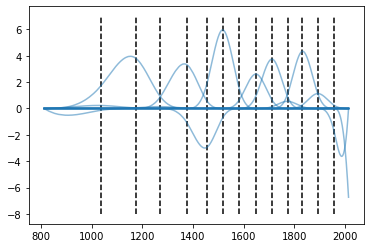

In [399]:
plt.plot(year_obs,
         B*weights_mu,
         "C0",
         alpha=0.5);
plt.vlines(knot_list[1:-1],
           ymin=-8,
           ymax=7,
           colors="k",
           linestyle="--")

In [407]:
# Sample posterior distribution, this way we get a sample for doy
with spline_model:
    doy_samples = pm.sample_posterior_predictive(spline_trace,
                                                 samples=1000)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [421]:
spline_trace["doy_mu"].mean(0).shape

(827,)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:>

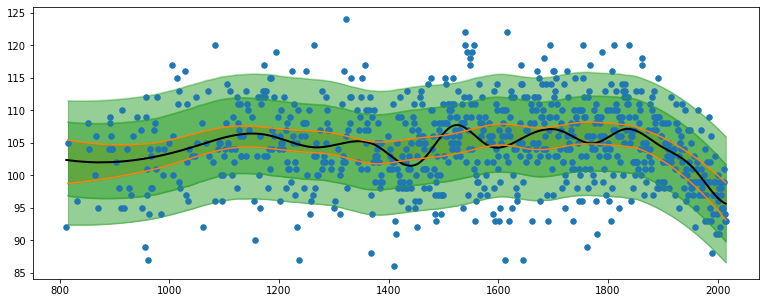

In [422]:
_, ax = plt.subplots(figsize=(13,5))

ax.plot(year_obs,
        doy_obs,
        "C0.",
        markersize=11
       )
ax.plot(year_obs,
        spline_trace["doy_mu"].mean(0),
        "k",
        linewidth=2)
# Note that this is hdi plot for the value of doy_mu and not for doy
az.plot_hdi(year_obs,
            spline_trace["doy_mu"],
            hdi_prob=0.97,
            plot_kwargs={"alpha": 1},
            ax=ax
           )
# This is instead the hdi for the overall value for doy calculated from the sampled posterior
az.plot_hdi(year_obs,
            doy_samples["doy"],
            hdi_prob=0.67,
            color="C2",
            plot_kwargs={"alpha": 0.6})
az.plot_hdi(year_obs,
            doy_samples["doy"],
            hdi_prob=0.89,
            color="C2",
            plot_kwargs={"alpha":0.3})

***
### Exercises

#### Ex. M1

In [430]:
# Define priors
mu = stats.norm(loc=0, scale=10)
sigma = stats.expon(1)

In [431]:
# Sample priors
num_samples = 1_000
mu_samples = mu.rvs(num_samples)
sigma_samples = sigma.rvs(num_samples)

In [436]:
# Sample likelihood
y = stats.norm(loc=mu_samples, scale=sigma_samples)

In [437]:
y

In [434]:
y_samples = y.rvs(size=1000)

<AxesSubplot:>

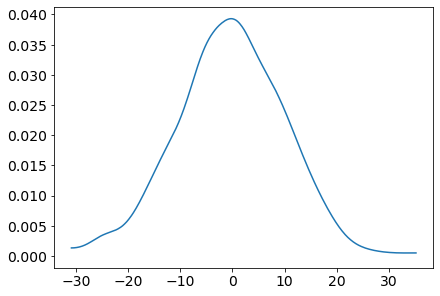

In [435]:
az.plot_kde(y_samples)

#### Ex. M4

$\alpha$ ~ Normal(150, 10) 

$\beta$ ~ Lognormal(0, 10) 

$\sigma$ ~ Exponential(1/20)

$\mu_{i} = \alpha + \beta * (year_{i} - \overline{year})$

$h_{i}$ ~ Normal($\mu_{i}$, $\sigma$) 

Possibly we should add time dependence of sigma

#### Ex. M5

$\sigma$ ~ Exponential(1/64)

#### Ex. M6

In [439]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")
adults = df.query("age >= 18")
height_obs = adults["height"]
weight_obs = adults["weight"]
weight_cent = weight_obs - weight_obs.mean()

##### Centered model

In [442]:
with pm.Model() as cent_model:
    # Priors
    alpha = pm.Normal("alpha",
                      mu=178,
                      sd=20)
    beta = pm.Lognormal("beta",
                        mu=0,
                        sd=1)
    
    height_mu = pm.Deterministic("height_mu",
                                 var=alpha + beta*weight_cent)
    height_sd = pm.Uniform("height_sd",
                           lower=0,
                           upper=50)
    
    # Likelihood
    height = pm.Normal("height",
                       mu=height_mu,
                       sd=height_sd,
                       observed=height_obs)

In [443]:
with cent_model:
    cent_trace = pm.sample(1000,
                           return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [height_sd, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'height_sd'}>,
        <AxesSubplot:title={'center':'height_sd'}>]], dtype=object)

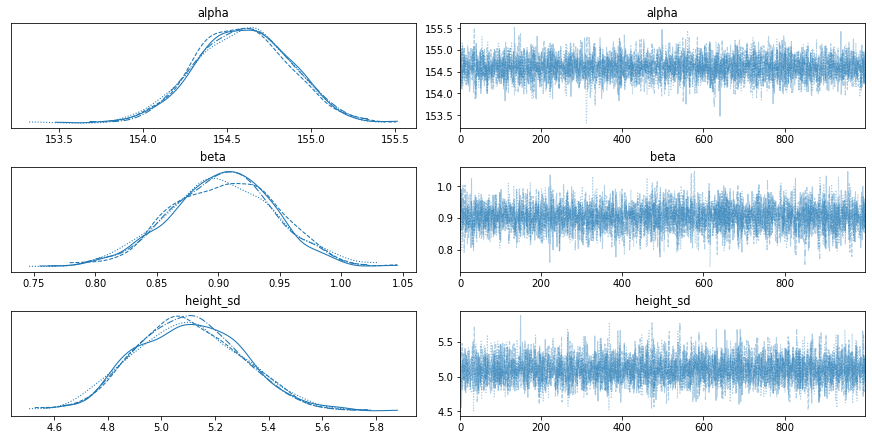

In [444]:
az.plot_trace(cent_trace, var_names=["~height_mu"])

In [445]:
az.summary(cent_trace, var_names=["~height_mu"], kind="stats", round_to=3)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,154.595,0.275,154.101,155.124
beta,0.903,0.043,0.822,0.982
height_sd,5.102,0.197,4.758,5.475


In [450]:
cent_trace_df = pm.trace_to_dataframe(cent_trace, varnames=["alpha", "beta", "height_sd"])

In [451]:
cent_trace_df.corr()

,alpha,beta,height_sd
alpha,1.000000,0.012794,0.002662
beta,0.012794,1.000000,-0.018045
height_sd,0.002662,-0.018045,1.000000


In [452]:
# Posterior predictions

with cent_model:
    cent_samples = pm.sample_posterior_predictive(cent_trace,
                                                  samples=1000)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<AxesSubplot:>

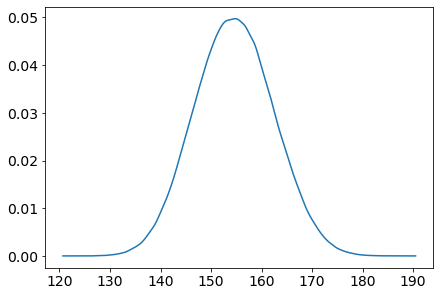

In [454]:
az.plot_kde(cent_samples["height"])

##### Uncentered model

In [457]:
with pm.Model() as unct_model:
    # Priors
    alpha = pm.Normal("alpha",
                      mu=0,
                      sd=30)
    beta = pm.Lognormal("beta",
                        mu=0,
                        sd=1)
    
    height_mu = pm.Deterministic("height_mu",
                                 var=alpha + beta*weight_obs)
    height_sd = pm.Uniform("height_sd",
                           lower=0,
                           upper=50)
    
    # Likelihood
    height = pm.Normal("height",
                       mu=height_mu,
                       sd=height_sd,
                       observed=height_obs)

In [458]:
with unct_model:
    unct_trace = pm.sample(1000,
                           return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [height_sd, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'height_sd'}>,
        <AxesSubplot:title={'center':'height_sd'}>]], dtype=object)

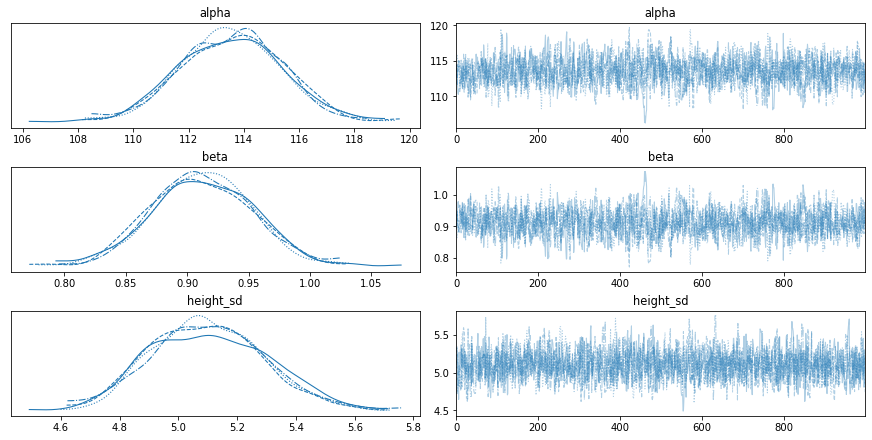

In [459]:
az.plot_trace(unct_trace, var_names=["~height_mu"])

In [460]:
az.summary(unct_trace, var_names=["~height_mu"], kind="stats", round_to=2)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,113.55,1.88,109.98,116.98
beta,0.91,0.04,0.83,0.99
height_sd,5.10,0.19,4.76,5.46


In [461]:
az.summary(cent_trace, var_names=["~height_mu"], kind="stats", round_to=2)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
alpha,154.6,0.28,154.10,155.12
beta,0.9,0.04,0.82,0.98
height_sd,5.1,0.20,4.76,5.48


In [462]:
pm.trace_cov(unct_trace, vars=["alpha", "beta", "height_sd"], model=unct_model)

array([[ 3.55268828e+00, -8.52315634e-02, -5.74840323e-04],
       [-8.52315634e-02,  2.08953769e-03,  1.34206983e-05],
       [-5.74840323e-04,  1.34206983e-05,  1.77361729e-03]])

In [463]:
unct_trace_df = pm.trace_to_dataframe(unct_trace, varnames=["alpha", "beta", "height_sd"])

In [464]:
unct_trace_df.corr()

,alpha,beta,height_sd
alpha,1.000000,-0.989677,-0.006910
beta,-0.989677,1.000000,0.007727
height_sd,-0.006910,0.007727,1.000000


In [465]:
cent_trace_df.corr()

,alpha,beta,height_sd
alpha,1.000000,0.012794,0.002662
beta,0.012794,1.000000,-0.018045
height_sd,0.002662,-0.018045,1.000000


Not centering the data results in a strong correlation between alpha and beta. One could see this by thinking that as alpha is now on one side of the data moving it up and down can still allow us to get a good fit as long as we also change the slope of the line

In [466]:
# Posterior predictions

with unct_model:
    unct_samples = pm.sample_posterior_predictive(unct_trace,
                                                  samples=1000)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


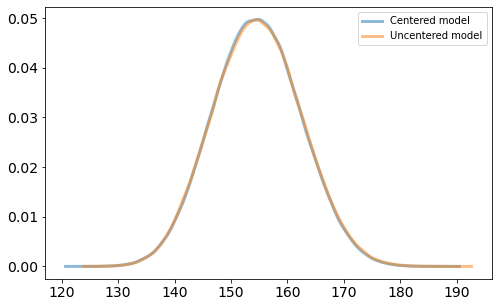

In [470]:
_, ax = plt.subplots(figsize=(8,5))

az.plot_kde(cent_samples["height"], 
            plot_kwargs={
                "color": "C0",
                "alpha": 0.5,
                "linewidth": 3
            },
            label="Centered model",
            ax=ax)
az.plot_kde(unct_samples["height"], 
            plot_kwargs={
                "color": "C1",
                "alpha": 0.5,
                "linewidth": 3
            },
            label="Uncentered model",
            ax=ax)
ax.legend()

At the end of the day the results from the posterior distribution appear to be very similar.

#### Ex. M8

In [472]:
df = pd.read_csv("../Data/cherry_blossoms.csv")

In [475]:
cherry = (df
          .copy()
          .loc[:, ["year", "doy"]]
          .dropna(subset=["doy"])
         )

In [476]:
year_obs = cherry["year"]
doy_obs = cherry["doy"]

##### More knots

In [477]:
# Generate knots
num_knots = 30
knot_list = np.quantile(year_obs, q=np.linspace(0, 1, num_knots))

# Generate splines
fml = "bs(year, knots=knots, degree=3) - 1"
B_30 = dmatrix(
    fml,
    data={"year": year_obs,
          "knots": knot_list[1:-1]}
)

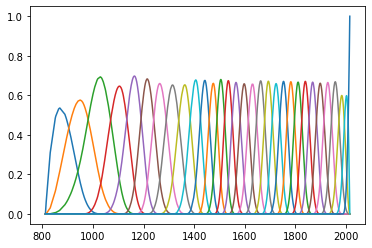

In [481]:
plt.plot(year_obs, 
         B_30.base);

In [482]:
# Define the model
with pm.Model() as more_knots_model:
    # Priors
    alpha = pm.Normal("alpha",
                      mu=100,
                      sd=10)
    weights = pm.Normal("weights",
                        mu=0,
                        sd=10,
                        shape=B_30.shape[1])
    doy_mu = pm.Deterministic("doy_mu",
                              alpha + pm.math.dot(B_30.base, weights))
    doy_sd = pm.Exponential("doy_sd",
                            lam=0.2)
    
    # Likelihood
    doy = pm.Normal("doy",
                    mu=doy_mu,
                    sd=doy_sd,
                    observed=doy_obs)

In [514]:
with more_knots_model:
    more_knots_trace = pm.sample(1000,
                                 return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [doy_sd, weights, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [546]:
stacked_post =  more_knots_trace.posterior.stack(draws=("chain", "draw"))

In [547]:
weight_mu = stacked_post.weights.values.mean(axis=1)

In [537]:
weight_mu.shape

(31,)

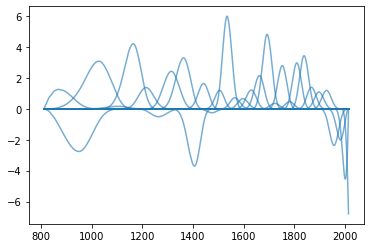

In [538]:
plt.plot(year_obs,
         B_30.base * weight_mu,
         "C0-",
         alpha=0.6);

In [539]:
# Sample from posterior

with more_knots_model:
    doy_samples = pm.sample_posterior_predictive(more_knots_trace,
                                                 1000
                                                )

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [540]:
doy_samples["doy"].mean(0).shape

(827,)

In [552]:
stacked_post.doy_mu.values.shape

(827, 4000)

C:\Users\andri\anaconda3\envs\bayes\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


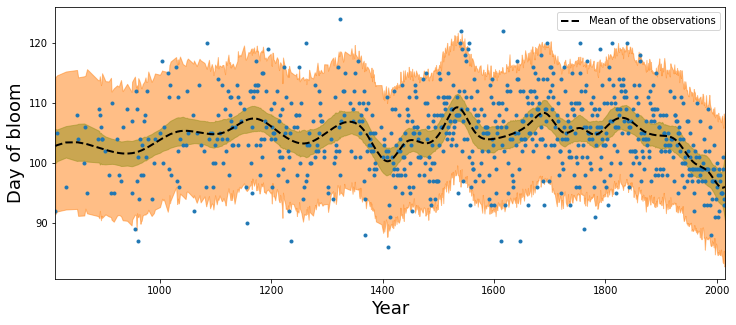

In [572]:
_, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    year_obs,
    doy_obs,
    "C0."
)
ax.plot(
    year_obs,
    stacked_post.doy_mu.values.mean(1),
    "k--",
    linewidth=2,
    label="Mean of the observations"
)
# az.plot_hdi(
#     year_obs,
#     stacked_post.doy_mu.values.T,
#     hdi_prob=0.67,
#     color="C2",
#     ax=ax,
# )
# az.plot_hdi(
#     year_obs,
#     doy_samples["doy"],
#     hdi_prob=0.67,
#     ax=ax,
# )


ax.fill_between(
    year_obs,
    az.hdi(stacked_post.doy_mu.values.T)[:,0],
    az.hdi(stacked_post.doy_mu.values.T)[:,1],
    color="C2",
    alpha=0.5)

ax.fill_between(
    year_obs,
    az.hdi(doy_samples["doy"])[:,0],
    az.hdi(doy_samples["doy"])[:,1],
    color="C1",
    alpha=0.5)

ax.set_xlim(year_obs.min(), year_obs.max())
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Day of bloom", fontsize=18)
ax.legend()


#### Ex. H1

In [574]:
df = pd.read_csv("../Data/Howell1.csv", sep=";")
adults = (df
          .copy()
          .query("age >= 18")
         )
height_obs = adults["height"]
weight_obs = adults["weight"]
weight_cent = weight_obs - weight_obs.mean()

In [576]:
with pm.Model() as pred_new_values_model:
    W = pm.Data("W",
                weight_cent)
    
    # Priors
    alpha = pm.Normal("alpha",
                      mu=178,
                      sd=20
                     )
    beta = pm.Lognormal("beta",
                        mu=0,
                        sd=1
                       )
    h_mu = pm.Deterministic("h_mu",
                            var=alpha + beta*W
                           )
    h_sd = pm.Exponential("h_sd",
                          lam=1/30)
    
    # Likelihood
    h = pm.Normal("h",
                  mu=h_mu,
                  sd=h_sd,
                  observed=height_obs
                 )

In [577]:
with pred_new_values_model:
    trace = pm.sample(1000,
                      return_inferencedata=True
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h_sd, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [591]:
# Arrays of values to predict 
W_new = np.array([46.95, 43.72, 64.78, 32.59, 54.63]) - weight_obs.mean()

In [592]:
with pred_new_values_model:
    pm.set_data({"W": W_new})
    pred = pm.sample_posterior_predictive(trace,
                                          1000
                                         )

In [593]:
pred["h"].mean(0)

array([156.45822137, 153.32968723, 172.52243064, 143.33891009,
       163.4858867 ])

In [594]:
az.hdi(pred["h"], hdi_prob=0.89)

array([[147.53906561, 163.3685496 ],
       [145.18405216, 162.22068591],
       [163.56979406, 180.1237203 ],
       [135.33942269, 152.24988952],
       [156.75134957, 172.12089457]])

#### Ex. H2

In [596]:
youth = (df
         .copy()
         .query("age < 18")
        )
height_obs = youth["height"]
weight_obs = youth["weight"]
weight_cent = weight_obs - weight_obs.mean()

In [598]:
with pm.Model() as youth_model:
    W = pm.Data("W",
                weight_cent)
    
    alpha = pm.Normal("alpha",
                      mu=170,
                      sd=20
                     )
    beta = pm.Lognormal("beta",
                        mu=0,
                        sd=10
                       )
    h_mu = pm.Deterministic("h_mu",
                            var=alpha + beta*W
                           )
    h_sd = pm.Exponential("h_sd",
                          lam=1/30
                         )
    h = pm.Normal("h",
                  mu=h_mu,
                  sd=h_sd,
                  observed=height_obs
                 )

In [600]:
with youth_model:
    mean_q = pm.find_MAP()
    Hess = pm.find_hessian(mean_q,
                           vars=[alpha, beta, h_sd]
                          )

In [609]:
Hess

array([[ 2.70352745e+00, -7.21644966e-16, -3.65444006e-02],
       [-7.21644966e-16,  2.14718504e+02,  8.81740132e-02],
       [-3.65444006e-02,  8.81740132e-02,  5.41392462e+00]])

In [601]:
var_cov = np.linalg.inv(Hess)

In [602]:
sigma_q = np.sqrt(var_cov)

<ipython-input-602-517cd53b4dc6>:1: RuntimeWarning: invalid value encountered in sqrt
  sigma_q = np.sqrt(var_cov)


In [605]:
var_cov

array([[ 3.69920879e-01, -1.02539577e-06,  2.49701061e-03],
       [-1.02539577e-06,  4.65729162e-03, -7.58580132e-05],
       [ 2.49701061e-03, -7.58580132e-05,  1.84726979e-01]])

In [606]:
sigma_q = np.nan_to_num(sigma_q, nan=0.0)

In [619]:
approx_posterior = stats.multivariate_normal(mean=[mean_q[key] for key in ["alpha", "beta", "h_sd"]],
                                             cov = sigma_q)

In [660]:
w_seq = np.arange(0, 50, 1) 
w_seq_cent = w_seq - weight_obs.mean()
sample_from_posterior = approx_posterior.rvs(1000) #samples of type [alpha, beta, h_sd]

# Calculate behavior of average
h_mu_pred = np.array(
    [az.hdi(sample_from_posterior[:, 0] + sample_from_posterior[:, 1]*w, hdi_prob=0.89) for w in w_seq_cent]
)

# Calculate behavior of predictions
h_pred = np.array(
    [az.hdi(np.random.normal(loc=sample_from_posterior[:, 0] + sample_from_posterior[:, 1]*w,
                             scale=sample_from_posterior[:, 2]), hdi_prob=0.89) for w in w_seq_cent]
)

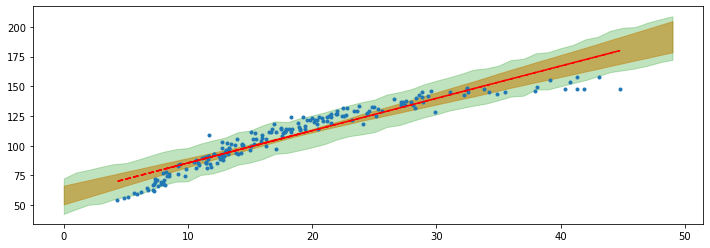

In [661]:
mean_height = mean_q["alpha"] + mean_q["beta"]*weight_cent

_, ax = plt.subplots(figsize=(12, 4))

ax.plot(weight_obs,
        height_obs,
        "C0.",
        label="Observed data"
       )
ax.plot(weight_obs,
        mean_height,
        "r--",
        label="Mean from MAP regression"
       )
ax.fill_between(w_seq,
                h_mu_pred[:, 0],
                h_mu_pred[:, 1],
                color="C1",
                alpha=0.6
               )
ax.fill_between(w_seq,
                h_pred[:, 0],
                h_pred[:, 1],
                color="C2",
                alpha=0.3
               )

If